In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import cv2
import numpy as np
from libs.forward_lib.read_data import ReadData
from libs.forward_lib.physical_model import PhysicalModel
from libs.forward_lib.physical_model import conv_3D
from libs.forward_lib.field_model import FieldModel
from libs.forward_lib.visualizer import vis_3d
import libs.forward_lib.physical_model
import libs.forward_lib.visualizer as vs
from libs.forward_lib.visualizer import visualize_SSIM

from skimage.metrics import structural_similarity as ssim


In [3]:
field_int_1 = torch.load('field_int_1.pt')
field_int_2 = torch.load('field_int_2.pt')

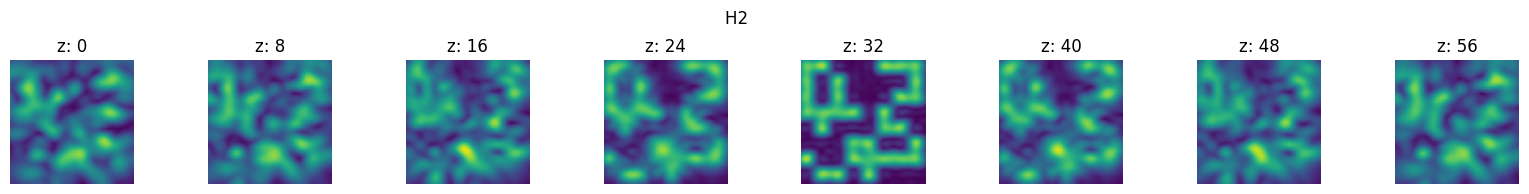

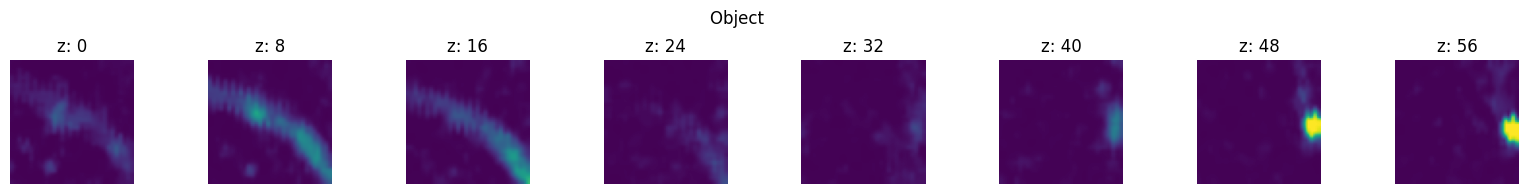

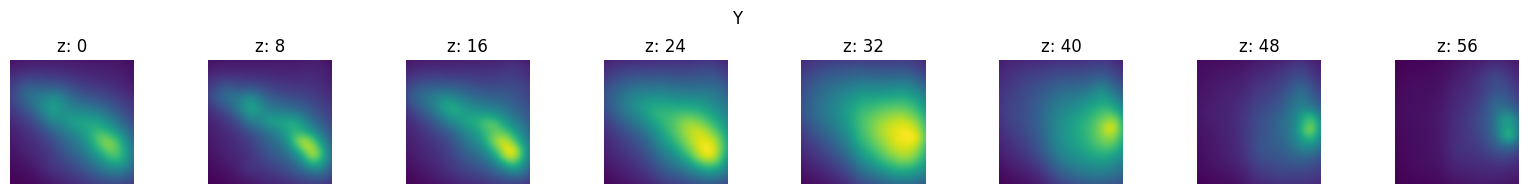

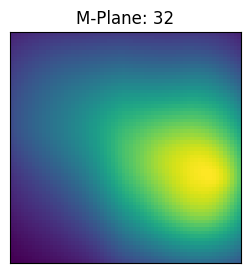

In [4]:
nx, ny, nz = 64, 64, 64
m = 2
dd_factor = 1
up_factor = 2

RD = ReadData(nx, ny, nz, up_factor=up_factor)
RD.load_object("blood_cell")


PM = PhysicalModel(nx, ny, nz, m, dd_factor=dd_factor)
measurements = PM.propagate_object(RD.X, verbose=3)             # verbose: [0, 1, 2, 3]

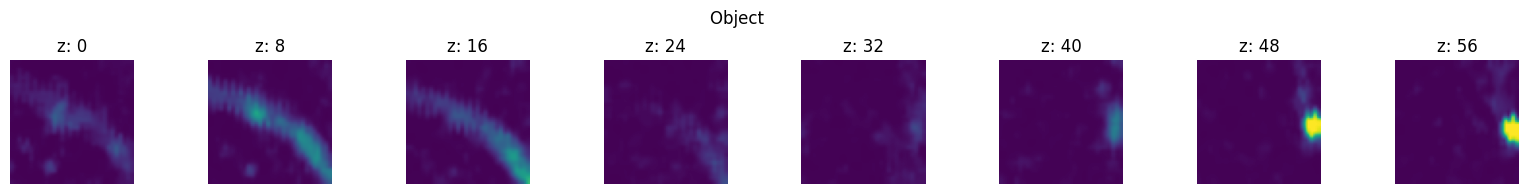

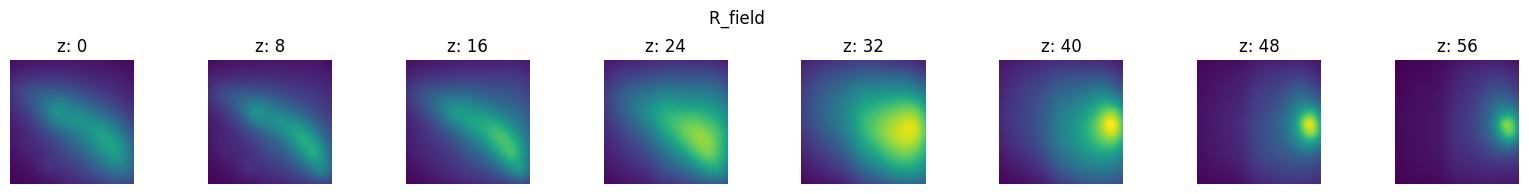

In [5]:
out = RD.X.squeeze() * field_int_1
Y_field = conv_3D(PM.emPSF_3D, out.unsqueeze(dim=0),PM.w).abs()[0]     # field around the detector
det_Y_field = Y_field[PM.m_planes, :, :]
scale_factor = (1, 1/PM.dd_factor, 1/PM.dd_factor) if len(det_Y_field.shape)==3 else (1/PM.dd_factor, 1/PM.dd_factor)
det_Y_field = nn.functional.interpolate(det_Y_field.unsqueeze(0).unsqueeze(0), scale_factor=scale_factor, mode='area').squeeze()

I = RD.X[0].detach().cpu().numpy()
R_field = Y_field.detach().cpu().numpy()
vs.show_planes(I, title=f"Object", N_z=PM.nz)
vs.show_planes(R_field, title=f'R_field', N_z=PM.nz)

In [6]:
PM.Y = (PM.Y-PM.Y.min())/(PM.Y.max() - PM.Y.min())
R_field = (R_field-R_field.min())/(R_field.max() - R_field.min())
field_int_1 = (field_int_1-field_int_1.min())/(field_int_1.max() - field_int_1.min())


In [7]:
img_tensor1 = ((PM.Y)*255).int()
img_tensor2 = (torch.tensor(R_field)*255).int()
img_tensor3 = (torch.tensor(field_int_1)*255).int()


C:\Users\farha\AppData\Local\Temp\ipykernel_15184\333685830.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor3 = (torch.tensor(field_int_1)*255).int()


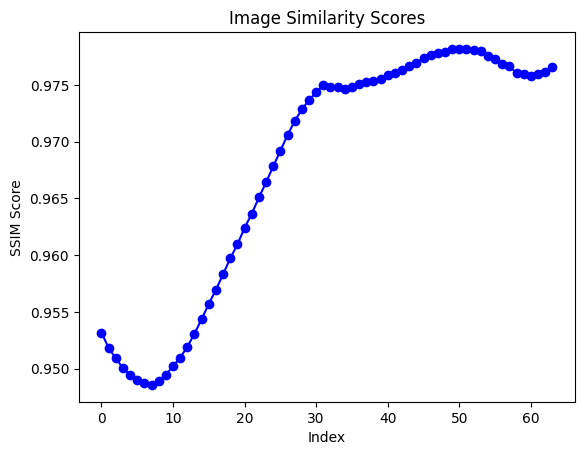

In [8]:
def calculate_image_similarity(tensor1, tensor2):
    assert len(tensor1) == len(tensor2)

    ssim_scores = []
    for index in range(tensor1.shape[0]):

        img1_np = tensor1[index].cpu().numpy()
        img2_np = tensor2[index].cpu().numpy()
        ssim_value, _ = ssim(img1_np, img2_np, full=True,data_range=256)
        ssim_scores.append(ssim_value)

    return ssim_scores



similarity_scores = calculate_image_similarity(img_tensor1, img_tensor2)

plt.plot(range(len(similarity_scores)), similarity_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('SSIM Score')
plt.title('Image Similarity Scores')
plt.show()


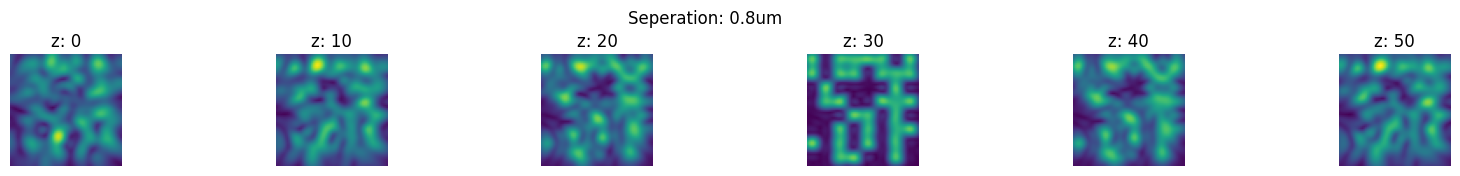

In [9]:
FM = FieldModel(nx,ny,nz)
FM.init_dmd()
FM.propagate_field()
FM.visualize_at_seperation(seperation = 0.8)

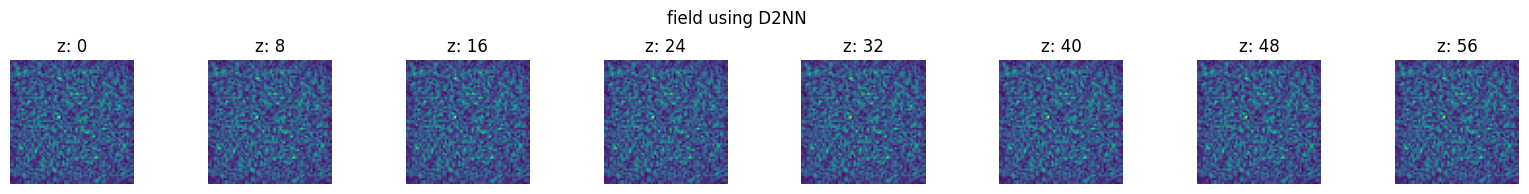

In [10]:
vs.show_planes(field_int_1.cpu().numpy(),title= "field using D2NN",N_z= PM.nz)

In [11]:
def calculate_ssim(img1, img2):

    # Convert images to numpy arrays
    img1_np = img1.cpu().numpy() if isinstance(img1, torch.Tensor) else np.asarray(img1)
    img2_np = img2.cpu().numpy() if isinstance(img2, torch.Tensor) else np.asarray(img2)

    # Check the number of channels
    if len(img1_np.shape) == 2 and len(img2_np.shape) == 2:
        # Images are already single-channel (grayscale)
        gray1 = img1_np
        gray2 = img2_np
    else:
        # Convert images to grayscale
        gray1 = cv2.cvtColor(img1_np, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2_np, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM value
    data_range = gray1.max() - gray1.min()
    ssim_index, _ = ssim(gray1, gray2, full=True, data_range=data_range)
    return ssim_index

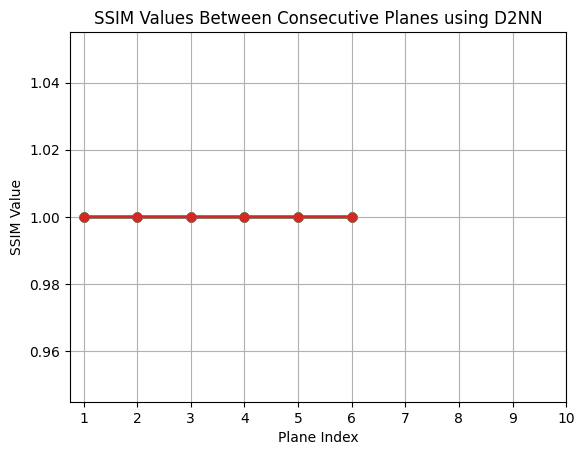

In [12]:
ssim_na = []

for i in range(img_tensor3.shape[0]):
    ssim_values = []
    for i in range(1,7):
        ssim_points = calculate_ssim(img_tensor3[8*i], img_tensor3[8*(i+1)])
        ssim_values.append(ssim_points)
    ssim_na.append(ssim_values)

for i, ssim_values in enumerate(ssim_na):
    plt.plot(range(1, len(ssim_values) + 1), ssim_values, marker='o')

plt.xticks(range(1, 11))
plt.title('SSIM Values Between Consecutive Planes using D2NN')
plt.xlabel('Plane Index')
plt.ylabel('SSIM Value')
plt.grid(True)
plt.show()

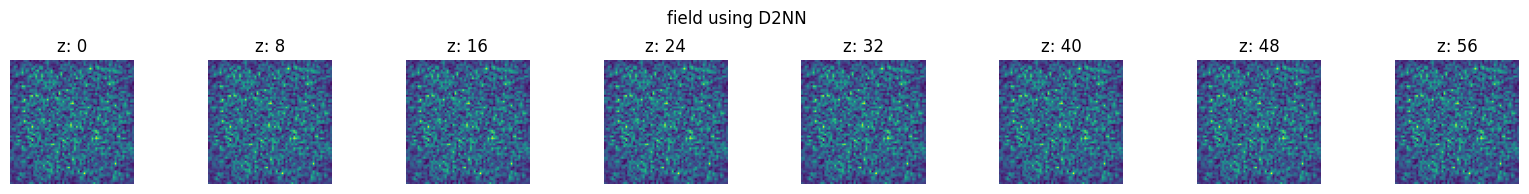

In [13]:
field_int_1 = torch.load('field_int_1.pt')

vs.show_planes(field_int_2.cpu().numpy(),title= "field using D2NN",N_z= PM.nz)